**Task 4**

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from patchify import patchify, unpatchify

import tensorflow as tf
import tensorflow.keras.backend as K
from keras.models import Model
import keras.backend as K
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# Specify the desired working directory
my_directory = r'C:\Users\User\Desktop\2023-24b-fai2-adsai-yuliiabobrovytska226038\1. Computer Vision\DataLab tasks\Task 4'

# Change the working directory
os.chdir(my_directory)

# Print the updated working directory
print("My working directory:", os.getcwd())

My working directory: C:\Users\User\Desktop\2023-24b-fai2-adsai-yuliiabobrovytska226038\1. Computer Vision\DataLab tasks\Task 4


In [3]:
parent_dir = "Dataset"
masks_dir = "Masks"
patch_dir = "Patched"

test_dir = "test"
train_dir = "train"

train_path = os.path.join(parent_dir, train_dir)
test_path = os.path.join(parent_dir, test_dir)

patch_train_path = os.path.join(patch_dir, train_dir)
patch_test_path = os.path.join(patch_dir, test_dir)

In [4]:
# Using images that is already read by cv2
def dim_crop(im):
    # Remove unnecessary pixels
    im = im[0:3000, 0:4000]
    
    # Filtering
    im_blurred = cv2.medianBlur(im, 5)
    th, output_im = cv2.threshold(im_blurred, 50, 250, cv2.THRESH_BINARY_INV)
    kernel = np.ones((11, 11), np.uint8)
    output_im = cv2.erode(output_im, kernel, iterations=1)
    output_im = cv2.dilate(output_im, kernel, iterations=1)

    # Get the dimensions of dish
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(output_im)
    x, y, w, h, _ = stats[0]

    # Check which side is longer to store in side_length, so no data will be lost
    side_length = max(w, h) - 20

    # This part ensures that the cropped image will be centered
    lx = max(min(x + w // 2 - side_length // 2, im.shape[1] - side_length), 0)
    ly = max(min(y + h // 2 - side_length // 2, im.shape[0] - side_length), 0)
    rx = lx + side_length
    ry = ly + side_length
    
    return ly, ry, lx, rx

In [5]:
def all_paths(fpath):
    image_file = os.path.basename(fpath)
        
    root_mask_path = image_file[:-4] + "_root_mask.tif"
    shoot_mask_path = image_file[:-4] + "_shoot_mask.tif"
    seed_mask_path = image_file[:-4] + "_seed_mask.tif"
    occ_root_mask_path = image_file[:-4] + "_occluded_root_mask.tif" 
    all_paths = [shoot_mask_path,root_mask_path, occ_root_mask_path, seed_mask_path]
    return all_paths

In [6]:
def check_all_paths(all_paths, masks_dir):
    for mask_path in all_paths:
        mask_full_path = os.path.join(masks_dir, mask_path)  # Construct the full file path
        if not os.path.exists(mask_full_path):
            return False  # Return False - a non-existing path is found
    return True  # Return True - after checking all paths and finding them all existing

In [7]:
def img_read(fpath):
    orig_img = cv2.imread(fpath)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)
    return orig_img

In [8]:
def img_resize(fpath, img_size):
    img = img_read(fpath)
    ly, ry, lx, rx = dim_crop(img)
    img = img[ly:ry, lx:rx]
    img = img/255
    img = cv2.resize(img, (img_size, img_size))
    return img

In [9]:
def to_get_the_masks(all_masks_paths, img_size, fpath, masks_dir):
    # Create a 5-channel map initialized with zeros
    masks = np.zeros((img_size, img_size, 5), dtype=np.float32)
    
    # The first channel is for background, initially set to 1 (assuming background is class 0)
    masks[:, :, 0] = 1

    for i, mask_path in enumerate(all_masks_paths):
        mask_full_path = os.path.join(masks_dir, mask_path)
        mask = cv2.imread(mask_full_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        ly, ry, lx, rx = dim_crop(img_read(fpath))  # Assuming these functions are defined elsewhere
        mask = mask[ly:ry, lx:rx]
        mask = cv2.resize(mask, (img_size, img_size))

        # Update the corresponding mask channel and the background channel
        masks[:, :, i+1][mask != 0] = 1  # Set 1s for the current class mask
        masks[:, :, 0][mask != 0] = 0    # Set corresponding background to 0

    return masks

In [10]:
def to_save_dataset_patched(fpath, settype, img_patches, mask_patches, patch_size, img_size):
    img_patches = img_patches.reshape(-1, patch_size, patch_size, 1)
    mask_patches = mask_patches.reshape(-1, patch_size, patch_size, 5)
    factor = img_size // patch_size

    img_patch_path = fpath.replace('Dataset', f'Patched/images/{settype}')
    for i, patch in enumerate(img_patches):
        col = (i + factor) // factor
        row = (i + factor) % factor + 1
        image_patch_path_numbered = f'{img_patch_path[:-4]}_{col}_{row}.png'
        cv2.imwrite(image_patch_path_numbered, patch)

    mask_patch_path = img_patch_path.replace('images', 'masks')
    print(mask_patch_path)
    mask_patch_path = f'{mask_patch_path[:-4]}_mask'
    for i, patch in enumerate(mask_patches):
        col = (i + factor) // factor
        row = (i + factor) % factor + 1
        mask_patch_path_numbered = f'{mask_patch_path}_{col}_{row}.png'
        cv2.imwrite(mask_patch_path_numbered, patch)

In [11]:
def create_dataset(path, settype, masks_dir, img_size, patch_size):
    X = []
    y = []
    for fpath in glob.glob(path + '/*.png'):
        all_masks_paths = all_paths(fpath)
        
        if not check_all_paths(all_masks_paths, masks_dir):
            continue

        img = img_resize(fpath, img_size)
        mask = to_get_the_masks(all_masks_paths, img_size, fpath, masks_dir)
        
        img_patches = patchify(img, (patch_size, patch_size), step=patch_size)
        mask_patches = patchify(mask, (patch_size, patch_size, 5), step=patch_size)
        
        #save_patched_dataset(fpath, settype, img_patches, mask_patches, patch_size, img_size)

        X.append(img_patches)
        y.append(mask_patches)

    X = np.array(X)
    y = np.array(y)
    y = np.squeeze(y, axis=3)

    print("Dataset: X =", X.shape, ", y =", y.shape)

    return X, y

In [12]:
X_train, y_train = create_dataset(train_path,'train', masks_dir, img_size=2048, patch_size=256)

Dataset: X = (58, 8, 8, 256, 256) , y = (58, 8, 8, 256, 256, 5)


In [13]:
X_test, y_test = create_dataset(test_path,'test', masks_dir, img_size=2048, patch_size=256)

Dataset: X = (27, 8, 8, 256, 256) , y = (27, 8, 8, 256, 256, 5)


In [14]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
print("Reshaped: X_train =", X_train.shape, ", y_train =", y_train.shape, ", X_test =", X_test.shape, ", y_test =", y_test.shape)

Reshaped: X_train = (58, 8, 8, 256, 256, 1) , y_train = (58, 8, 8, 256, 256, 5) , X_test = (27, 8, 8, 256, 256, 1) , y_test = (27, 8, 8, 256, 256, 5)


In [15]:
X_train = X_train.reshape(-1, 256,256, 1)
X_test = X_test.reshape(-1, 256,256, 1)
y_train = y_train.reshape(-1, 256,256, 5)
y_test = y_test.reshape(-1, 256,256, 5)
print("Reshaped: X_train =", X_train.shape, ", y_train =", y_train.shape, ", X_test =", X_test.shape, ", y_test =", y_test.shape)

Reshaped: X_train = (3712, 256, 256, 1) , y_train = (3712, 256, 256, 5) , X_test = (1728, 256, 256, 1) , y_test = (1728, 256, 256, 5)


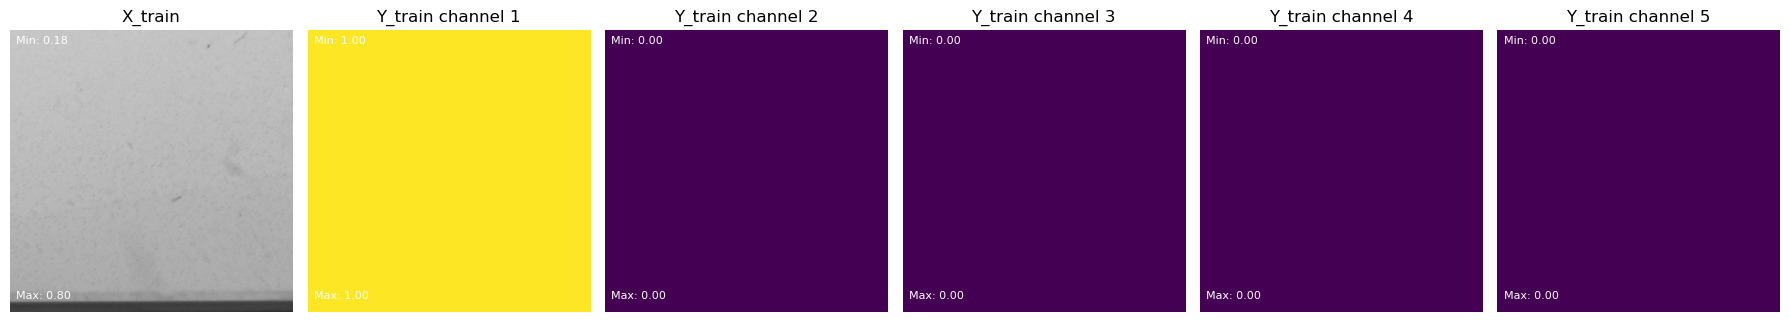

In [16]:
# Select a random sample from X_train and Y_train for visualization
sample_index = np.random.randint(0, len(X_train))

# Separate X_train and Y_train into individual channels
x_channel = X_train[sample_index, :, :, 0]  # Assuming X_train is (3840, 256, 256, 1)
y_channels = y_train[sample_index, :, :, :]   # Assuming Y_train is (3840, 256, 256, 5)

# Get min and max values of X_train
x_min = np.min(x_channel)
x_max = np.max(x_channel)

# Create subplots to display X_train and 5 channels of Y_train
fig, axes = plt.subplots(1, 6, figsize=(18, 4))

# Plot X_train with min and max annotations
axes[0].imshow(x_channel, cmap='gray', vmin=0, vmax=1)
axes[0].set_title('X_train')
axes[0].axis('off')
axes[0].text(5, 5, f'Min: {x_min:.2f}', color='white', fontsize=8, verticalalignment='top')
axes[0].text(5, 245, f'Max: {x_max:.2f}', color='white', fontsize=8, verticalalignment='bottom')

# Plot each channel of Y_train
for i in range(5):
    channel = y_channels[:, :, i]
    axes[i + 1].imshow(channel, cmap='viridis', vmin=0, vmax=1)  # You can change the colormap as needed
    axes[i + 1].set_title(f'Y_train channel {i + 1}')
    axes[i + 1].axis('off')
    min_val = np.min(channel)
    max_val = np.max(channel)
    axes[i + 1].text(5, 5, f'Min: {min_val:.2f}', color='white', fontsize=8, verticalalignment='top')
    axes[i + 1].text(5, 245, f'Max: {max_val:.2f}', color='white', fontsize=8, verticalalignment='bottom')


plt.tight_layout()
plt.show()

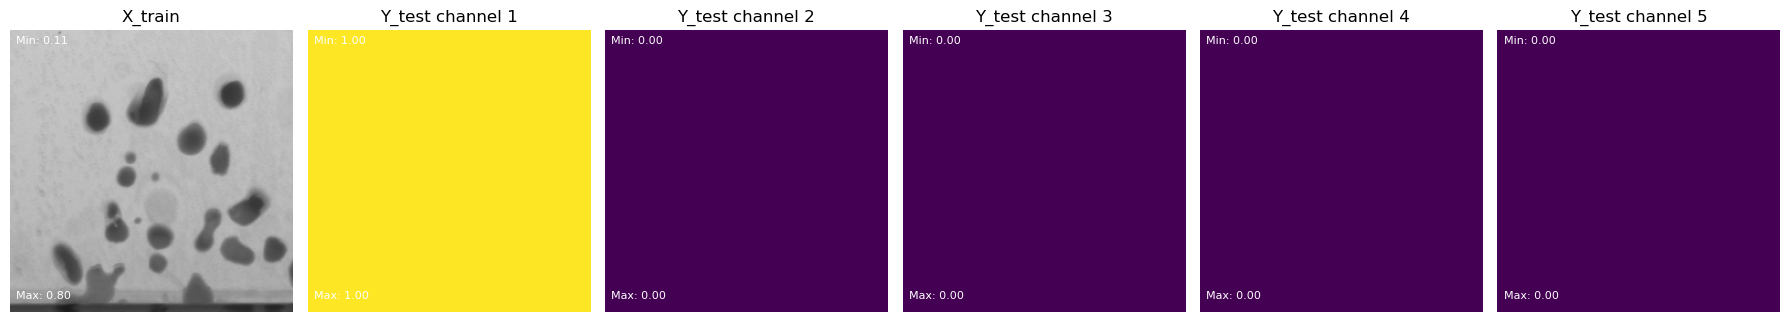

In [17]:
# Select a random sample from X_train and Y_train for visualization
sample_index = np.random.randint(0, len(X_test))

# Separate X_train and Y_train into individual channels
x_channel = X_test[sample_index, :, :, 0]  # Assuming X_train is (3840, 256, 256, 1)
y_channels = y_test[sample_index, :, :, :]   # Assuming Y_train is (3840, 256, 256, 5)

# Get min and max values of X_train
x_min = np.min(x_channel)
x_max = np.max(x_channel)

# Create subplots to display X_train and 5 channels of Y_train
fig, axes = plt.subplots(1, 6, figsize=(18, 4))

# Plot X_train with min and max annotations
axes[0].imshow(x_channel, cmap='gray', vmin=0, vmax=1)
axes[0].set_title('X_train')
axes[0].axis('off')
axes[0].text(5, 5, f'Min: {x_min:.2f}', color='white', fontsize=8, verticalalignment='top')
axes[0].text(5, 245, f'Max: {x_max:.2f}', color='white', fontsize=8, verticalalignment='bottom')

# Plot each channel of Y_train
for i in range(5):
    channel = y_channels[:, :, i]
    axes[i + 1].imshow(channel, cmap='viridis', vmin=0, vmax=1)  # You can change the colormap as needed
    axes[i + 1].set_title(f'Y_test channel {i + 1}')
    axes[i + 1].axis('off')
    min_val = np.min(channel)
    max_val = np.max(channel)
    axes[i + 1].text(5, 5, f'Min: {min_val:.2f}', color='white', fontsize=8, verticalalignment='top')
    axes[i + 1].text(5, 245, f'Max: {max_val:.2f}', color='white', fontsize=8, verticalalignment='bottom')

plt.tight_layout()
plt.show()

In [18]:
y_train_root = y_train[:, :, :, 2:3]  # This slices out the third channel
y_test_root = y_test[:, :, :, 2:3]  # This slices out the third channel

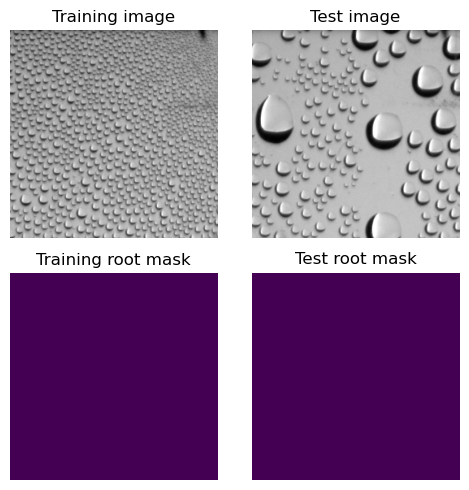

In [19]:
# Select a random sample from y_train_root and y_test_root for visualization
sample_index = np.random.randint(0, len(y_test_root))

# Get the root masks for the selected samples
train_root_mask = y_train_root[sample_index, :, :, 0]  # Squeeze the single channel
test_root_mask = y_test_root[sample_index, :, :, 0]  # Squeeze the single channel

# Get the corresponding input images for the selected samples
train_image = X_train[sample_index, :, :, 0]  # Assuming X_train has the same indexing as y_train_root
test_image = X_test[sample_index, :, :, 0]  # Assuming X_test has the same indexing as y_test_root

# Create subplots to display the training and test images and root masks
fig, axes = plt.subplots(2, 2, figsize=(5, 5))  # 2 rows, 2 columns

# Plot the training image
axes[0, 0].imshow(train_image, cmap='gray')
axes[0, 0].set_title('Training image')
axes[0, 0].axis('off')

# Plot the training root mask
axes[1, 0].imshow(train_root_mask, cmap='viridis')
axes[1, 0].set_title('Training root mask')
axes[1, 0].axis('off')

# Plot the test image
axes[0, 1].imshow(test_image, cmap='gray')
axes[0, 1].set_title('Test image')
axes[0, 1].axis('off')

# Plot the test root mask
axes[1, 1].imshow(test_root_mask, cmap='viridis')
axes[1, 1].set_title('Test root mask')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

**Binary model on roots**

In [20]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [21]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        total = K.sum(K.square(y_true),[1,2,3]) + K.sum(K.square(y_pred),[1,2,3])
        union = total - intersection
        return (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(f(y_true, y_pred), axis=-1)

In [22]:
# U-Net model
# Author: Sreenivas Bhattiprolu
# This code is coming from the videos at the beginning
def simple_bin_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
# Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1, iou])
    
    return model

In [23]:
root_model = simple_bin_unet_model(256, 256, 1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=2, restore_best_weights=True) 
history = root_model.fit(X_train, y_train_root, validation_data=(X_test, y_test_root), epochs=10, batch_size=32, callbacks=early_stop)

Epoch 1/10
116/116 [==============================] - 1379s 12s/step - loss: 0.0860 - accuracy: 0.9762 - f1: 0.0011 - iou: 0.0074 - val_loss: 0.0414 - val_accuracy: 0.9929 - val_f1: 0.0000e+00 - val_iou: 0.0106
Epoch 2/10
116/116 [==============================] - 1330s 11s/step - loss: 0.0470 - accuracy: 0.9894 - f1: 0.0239 - iou: 0.0238 - val_loss: 0.0323 - val_accuracy: 0.9916 - val_f1: 0.0456 - val_iou: 0.0490
Epoch 3/10
116/116 [==============================] - 1313s 11s/step - loss: 0.0256 - accuracy: 0.9923 - f1: 0.5535 - iou: 0.1362 - val_loss: 0.0156 - val_accuracy: 0.9950 - val_f1: 0.4070 - val_iou: 0.1317
Epoch 4/10
116/116 [==============================] - 1311s 11s/step - loss: 0.0170 - accuracy: 0.9939 - f1: 0.6809 - iou: 0.1758 - val_loss: 0.0110 - val_accuracy: 0.9959 - val_f1: 0.4834 - val_iou: 0.1719
Epoch 5/10
116/116 [==============================] - 1309s 11s/step - loss: 0.0151 - accuracy: 0.9944 - f1: 0.7082 - iou: 0.1876 - val_loss: 0.0110 - val_accuracy: 0.9

In [24]:
# Save the model
root_model.save('root_model.h5')

In [25]:
# Make predictions on the test set
root_y_pred = root_model.predict(X_test)

54/54 [==============================] - 102s 2s/step


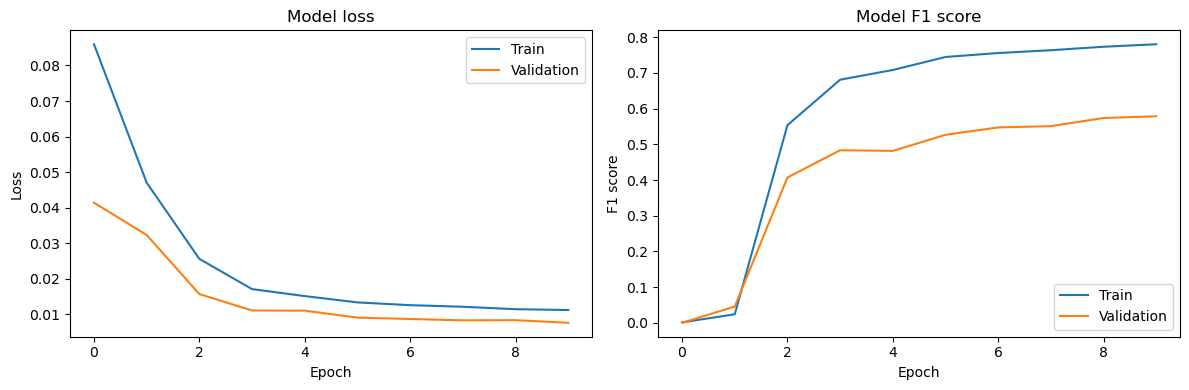

In [26]:
# Plotting learning curves
plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation F1 score values
plt.subplot(1, 2, 2)
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('Model F1 score')
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

In [27]:
def calculate_iou_with_threshold(y_true, y_pred, threshold):
    y_pred_binary = (y_pred > threshold).astype(int)
    
    intersection = np.sum(np.logical_and(y_true, y_pred_binary))
    union = np.sum(np.logical_or(y_true, y_pred_binary))
    
    iou_with_threshold = intersection / (union + 1e-10)  # Adding a small epsilon to avoid division by zero
    return iou_with_threshold

In [28]:
# Threshold for prediction
threshold = 0.5

# Calculate IoU without thresholding
test_iou = iou(y_test_root, root_y_pred).numpy().mean()
print(f'IoU on the test set without thresholding: {test_iou:.4f}')

# Calculate IoU with thresholding
test_iou_with_threshold = calculate_iou_with_threshold(y_test_root, root_y_pred, threshold)
print(f'IoU on the test set with thresholding (threshold={threshold}): {test_iou_with_threshold:.4f}')

IoU on the test set without thresholding: 0.2012
IoU on the test set with thresholding (threshold=0.5): 0.6249


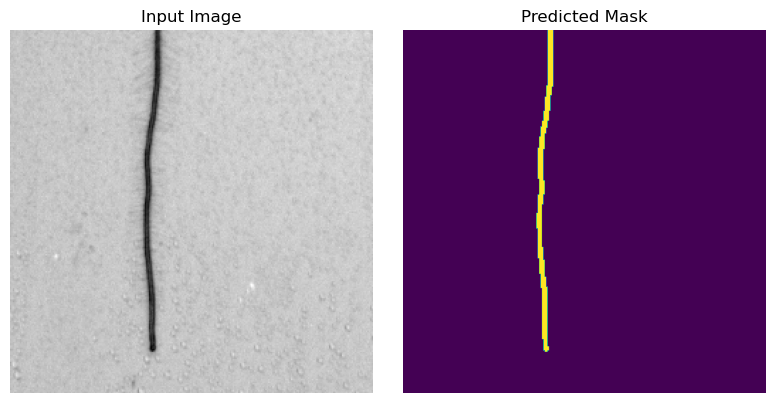

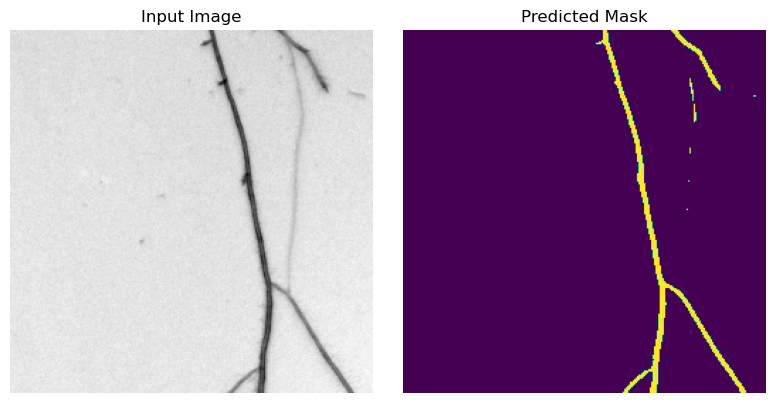

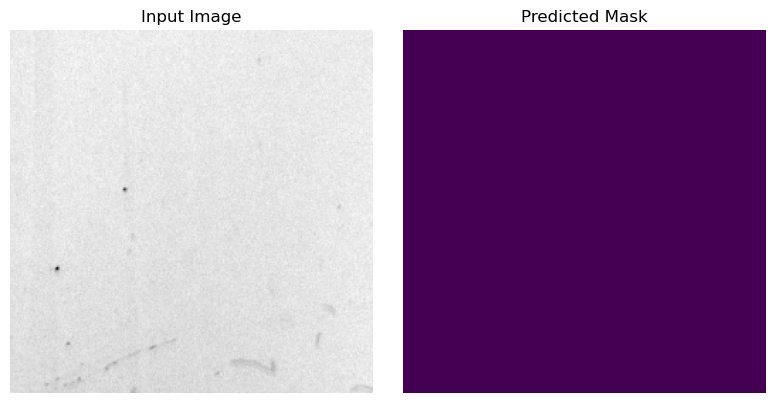

In [56]:
random_indices = np.random.choice(X_test.shape[0], 3, replace=False)

# Save example input images and resulting segmentation masks
for idx in random_indices:
    sample_image = X_test[idx]
    sample_mask_pred = root_y_pred[idx] > 0.5
    
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(sample_image, cmap='gray')
    plt.title('Input Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(sample_mask_pred, cmap='viridis', vmin=0, vmax=1)
    plt.title('Predicted Mask')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

**Binary model on seeds**

In [29]:
# Binary model on seed
y_train_seed = y_train[:, :, :, 3:4]  # This slices out the fourth channel
y_test_seed = y_test[:, :, :, 3:4]  # This slices out the fourth channel

In [30]:
seed_model = simple_bin_unet_model(256, 256, 1)

In [31]:
early_stop_seed = EarlyStopping(monitor='val_loss', patience=10, verbose=2, restore_best_weights=True)
history_seed = seed_model.fit(X_train, y_train_seed, validation_data=(X_test, y_test_seed), epochs=10, batch_size=32, callbacks=early_stop_seed)

Epoch 1/10
116/116 [==============================] - 1338s 11s/step - loss: 0.0114 - accuracy: 0.9975 - f1: 4.0220e-07 - iou: 5.3163e-05 - val_loss: 0.0012 - val_accuracy: 0.9999 - val_f1: 0.0000e+00 - val_iou: 1.2522e-04
Epoch 2/10
116/116 [==============================] - 1320s 11s/step - loss: 0.0011 - accuracy: 0.9999 - f1: 0.0000e+00 - iou: 1.0008e-04 - val_loss: 8.9879e-04 - val_accuracy: 0.9999 - val_f1: 0.0000e+00 - val_iou: 2.2587e-04
Epoch 3/10
116/116 [==============================] - 1311s 11s/step - loss: 0.0010 - accuracy: 0.9999 - f1: 0.0000e+00 - iou: 1.9579e-04 - val_loss: 8.2845e-04 - val_accuracy: 0.9999 - val_f1: 0.0000e+00 - val_iou: 5.1178e-04
Epoch 4/10
116/116 [==============================] - 1309s 11s/step - loss: 0.0010 - accuracy: 0.9999 - f1: 0.0000e+00 - iou: 3.4023e-04 - val_loss: 8.2088e-04 - val_accuracy: 0.9999 - val_f1: 0.0000e+00 - val_iou: 5.9228e-04
Epoch 5/10
116/116 [==============================] - 1310s 11s/step - loss: 0.0010 - accuracy: 

In [32]:
# Save the model
seed_model.save('seed_model.h5')

In [33]:
seed_y_pred = seed_model.predict(X_test)

54/54 [==============================] - 102s 2s/step


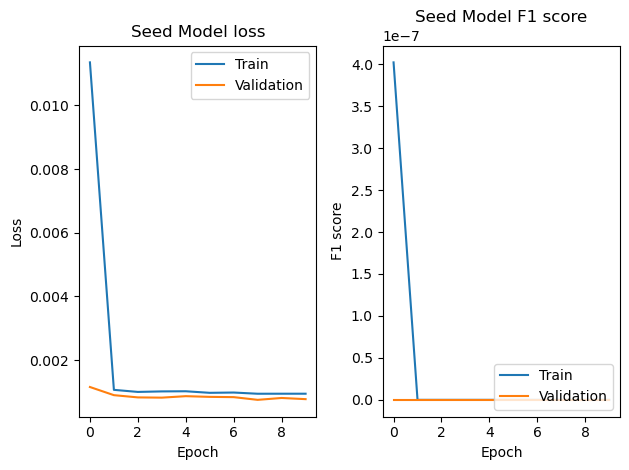

In [34]:
# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_seed.history['loss'])
plt.plot(history_seed.history['val_loss'])
plt.title('Seed Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation F1 score values
plt.subplot(1, 2, 2)
plt.plot(history_seed.history['f1'])
plt.plot(history_seed.history['val_f1'])
plt.title('Seed Model F1 score')
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

In [35]:
# Threshold for prediction
threshold = 0.5

# Calculate IoU without thresholding
seed_test_iou = iou(y_test_seed, seed_y_pred).numpy().mean()
print(f'IoU on the test set without thresholding: {seed_test_iou:.4f}')

# Calculate IoU with thresholding
seed_test_iou_with_threshold = calculate_iou_with_threshold(y_test_seed, seed_y_pred, threshold)
print(f'IoU on the test set with thresholding (threshold={threshold}): {seed_test_iou_with_threshold:.4f}')

IoU on the test set without thresholding: 0.0004
IoU on the test set with thresholding (threshold=0.5): 0.0000


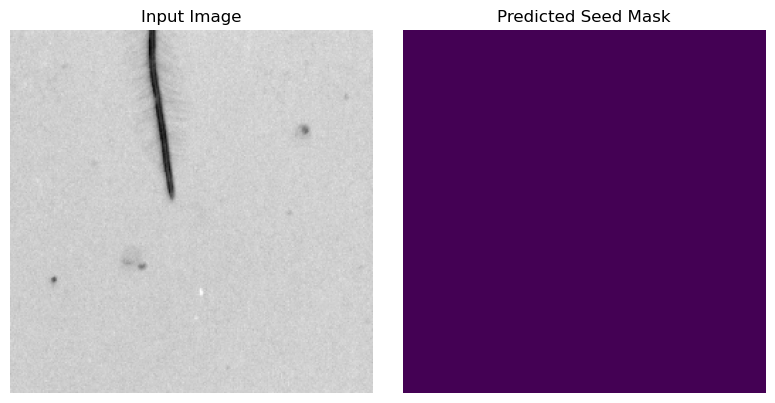

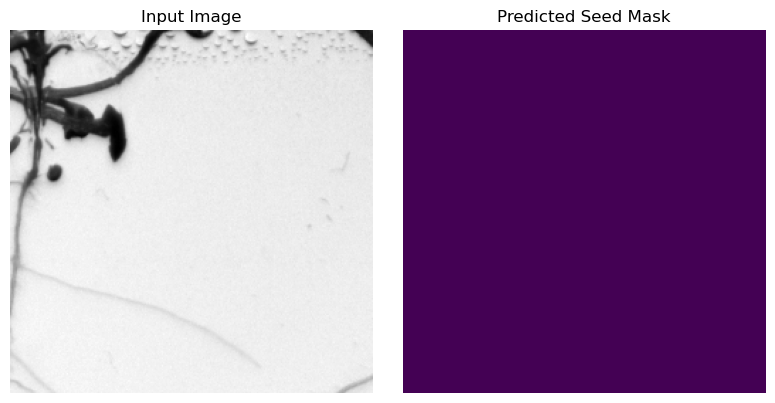

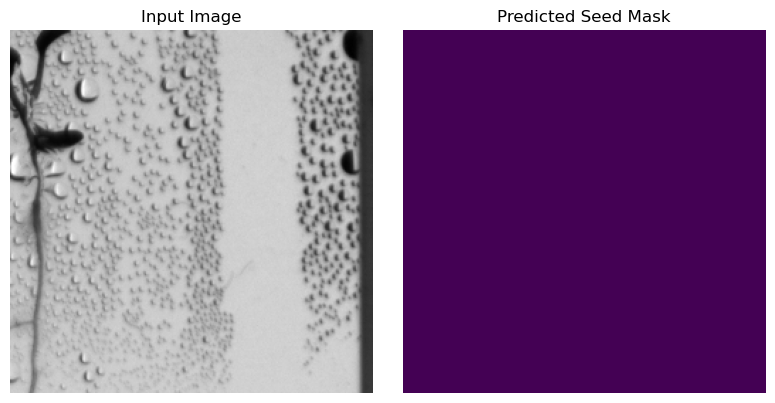

In [70]:
random_indices_4 = np.random.choice(X_test.shape[0], 3, replace=False)

# Save example input images and resulting segmentation masks for seed
for idx in random_indices_4:
    sample_image = X_test[idx]
    sample_mask_pred = seed_y_pred[idx] > 0.5
    
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(sample_image, cmap='gray')
    plt.title('Input Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(sample_mask_pred, cmap='viridis', vmin=0, vmax=1)
    plt.title('Predicted Seed Mask')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

**Binary model on shoots**

In [36]:
# Binary model on shoot
y_train_shoot = y_train[:, :, :, 1:2]  # This slices out the second channel
y_test_shoot = y_test[:, :, :, 1:2]  # This slices out the second channel

In [37]:
shoot_model = simple_bin_unet_model(256, 256, 1)

In [38]:
early_stop_shoot = EarlyStopping(monitor='val_loss', patience=10, verbose=2, restore_best_weights=True)
history_shoot = shoot_model.fit(X_train, y_train_shoot, validation_data=(X_test, y_test_shoot), epochs=10, batch_size=32, callbacks=early_stop_shoot)

Epoch 1/10
116/116 [==============================] - 1321s 11s/step - loss: 0.0856 - accuracy: 0.9614 - f1: 0.0014 - iou: 0.0226 - val_loss: 0.0160 - val_accuracy: 0.9932 - val_f1: 0.0011 - val_iou: 0.0455
Epoch 2/10
116/116 [==============================] - 1311s 11s/step - loss: 0.0152 - accuracy: 0.9932 - f1: 0.4194 - iou: 0.0613 - val_loss: 0.0134 - val_accuracy: 0.9947 - val_f1: 0.2615 - val_iou: 0.0812
Epoch 3/10
116/116 [==============================] - 1311s 11s/step - loss: 0.0123 - accuracy: 0.9953 - f1: 0.6323 - iou: 0.0739 - val_loss: 0.0126 - val_accuracy: 0.9954 - val_f1: 0.1696 - val_iou: 0.0489
Epoch 4/10
116/116 [==============================] - 1310s 11s/step - loss: 0.0101 - accuracy: 0.9963 - f1: 0.7360 - iou: 0.0816 - val_loss: 0.0137 - val_accuracy: 0.9949 - val_f1: 0.1491 - val_iou: 0.0535
Epoch 5/10
116/116 [==============================] - 1310s 11s/step - loss: 0.0089 - accuracy: 0.9968 - f1: 0.7908 - iou: 0.0852 - val_loss: 0.0098 - val_accuracy: 0.9967 

In [39]:
# Save the model
shoot_model.save('shoot_model.h5')

In [40]:
shoot_y_pred = shoot_model.predict(X_test)

54/54 [==============================] - 103s 2s/step


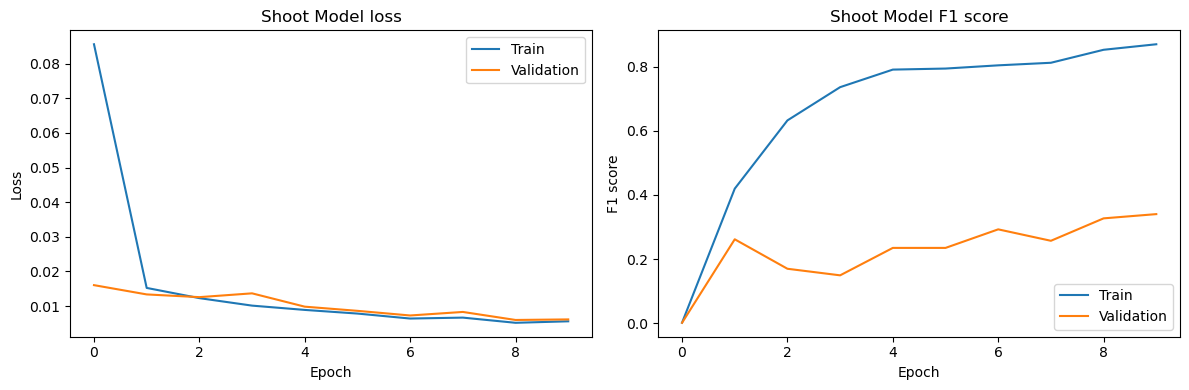

In [41]:
# Plotting learning curves for shoot
plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_shoot.history['loss'])
plt.plot(history_shoot.history['val_loss'])
plt.title('Shoot Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation F1 score values
plt.subplot(1, 2, 2)
plt.plot(history_shoot.history['f1'])
plt.plot(history_shoot.history['val_f1'])
plt.title('Shoot Model F1 score')
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

In [42]:
# Threshold for prediction
threshold = 0.5

# Calculate IoU without thresholding
shoot_test_iou = iou(y_test_shoot, shoot_y_pred).numpy().mean()
print(f'IoU on the test set without thresholding: {shoot_test_iou:.4f}')

# Calculate IoU with thresholding
shoot_test_iou_with_threshold = calculate_iou_with_threshold(y_test_shoot, shoot_y_pred, threshold)
print(f'IoU on the test set with thresholding (threshold={threshold}): {shoot_test_iou_with_threshold:.4f}')

IoU on the test set without thresholding: 0.0994
IoU on the test set with thresholding (threshold=0.5): 0.7042


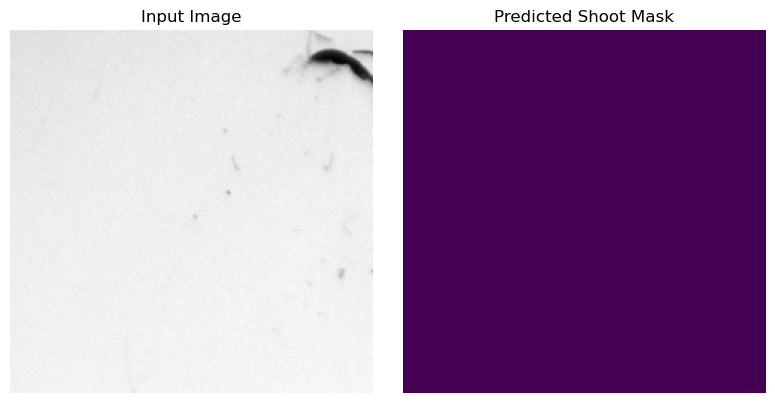

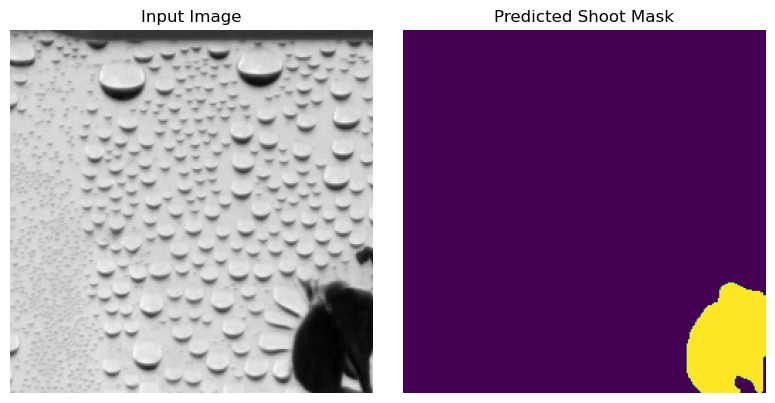

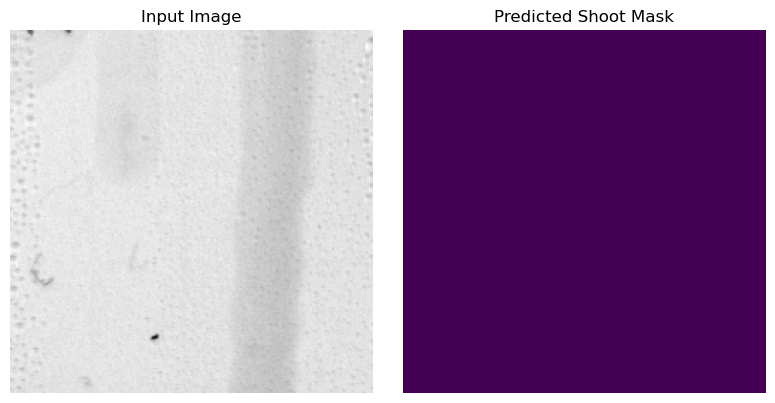

In [65]:
random_indices_2 = np.random.choice(X_test.shape[0], 3, replace=False)

# Save example input images and resulting segmentation masks for shoot
for idx in random_indices_2:
    sample_image = X_test[idx]
    sample_mask_pred = shoot_y_pred[idx] > 0.5
    
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(sample_image, cmap='gray')
    plt.title('Input Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(sample_mask_pred, cmap='viridis', vmin=0, vmax=1)
    plt.title('Predicted Shoot Mask')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

**Binary model on occuled_root**

In [43]:
# Binary model on occluded_root
y_train_occ_root = y_train[:, :, :, 2:3]  # This slices out the third channel
y_test_occ_root = y_test[:, :, :, 2:3]  # This slices out the third channel

In [44]:
occ_root_model = simple_bin_unet_model(256, 256, 1)

In [45]:
early_stop_occ_root = EarlyStopping(monitor='val_loss', patience=10, verbose=2, restore_best_weights=True)
history_occ_root = occ_root_model.fit(X_train, y_train_occ_root, validation_data=(X_test, y_test_occ_root), epochs=10, batch_size=32, callbacks=early_stop_occ_root)

Epoch 1/10
116/116 [==============================] - 1327s 11s/step - loss: 0.0597 - accuracy: 0.9890 - f1: 2.7631e-04 - iou: 0.0090 - val_loss: 0.0343 - val_accuracy: 0.9929 - val_f1: 0.0000e+00 - val_iou: 0.0167
Epoch 2/10
116/116 [==============================] - 1312s 11s/step - loss: 0.0369 - accuracy: 0.9905 - f1: 0.2978 - iou: 0.0829 - val_loss: 0.0219 - val_accuracy: 0.9942 - val_f1: 0.3768 - val_iou: 0.1192
Epoch 3/10
116/116 [==============================] - 1310s 11s/step - loss: 0.0243 - accuracy: 0.9927 - f1: 0.5968 - iou: 0.1465 - val_loss: 0.0135 - val_accuracy: 0.9959 - val_f1: 0.4748 - val_iou: 0.1503
Epoch 4/10
116/116 [==============================] - 1313s 11s/step - loss: 0.0177 - accuracy: 0.9938 - f1: 0.6843 - iou: 0.1753 - val_loss: 0.0115 - val_accuracy: 0.9961 - val_f1: 0.4967 - val_iou: 0.1608
Epoch 5/10
116/116 [==============================] - 1310s 11s/step - loss: 0.0154 - accuracy: 0.9944 - f1: 0.7133 - iou: 0.1871 - val_loss: 0.0101 - val_accuracy:

In [46]:
# Save the model
occ_root_model.save('occ_root_model.h5')

In [47]:
occ_root_y_pred = occ_root_model.predict(X_test)

54/54 [==============================] - 101s 2s/step


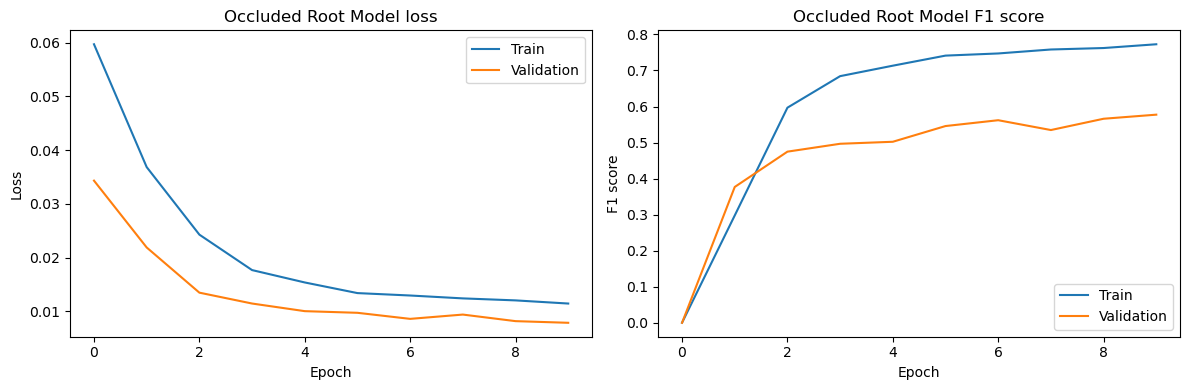

In [48]:
# Plotting learning curves for occluded_root
plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_occ_root.history['loss'])
plt.plot(history_occ_root.history['val_loss'])
plt.title('Occluded Root Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation F1 score values
plt.subplot(1, 2, 2)
plt.plot(history_occ_root.history['f1'])
plt.plot(history_occ_root.history['val_f1'])
plt.title('Occluded Root Model F1 score')
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

In [49]:
# Threshold for prediction
threshold = 0.5

# Calculate IoU without thresholding
occ_root_test_iou = iou(y_test_occ_root, occ_root_y_pred).numpy().mean()
print(f'IoU on the test set without thresholding: {occ_root_test_iou:.4f}')

# Calculate IoU with thresholding
occ_root_test_iou_with_threshold = calculate_iou_with_threshold(y_test_occ_root, occ_root_y_pred, threshold)
print(f'IoU on the test set with thresholding (threshold={threshold}): {occ_root_test_iou_with_threshold:.4f}')

IoU on the test set without thresholding: 0.1995
IoU on the test set with thresholding (threshold=0.5): 0.6185


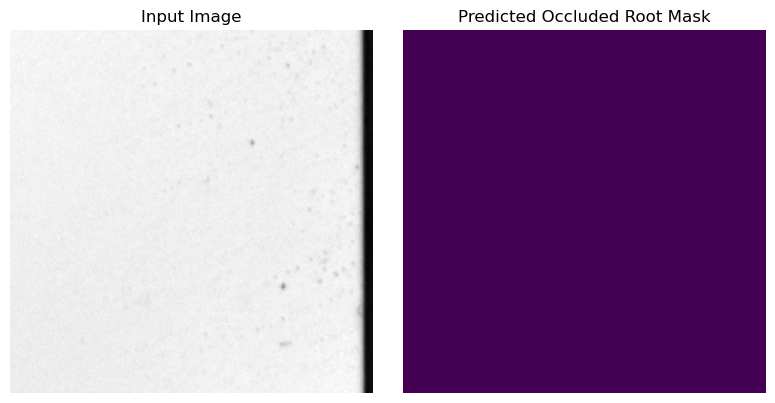

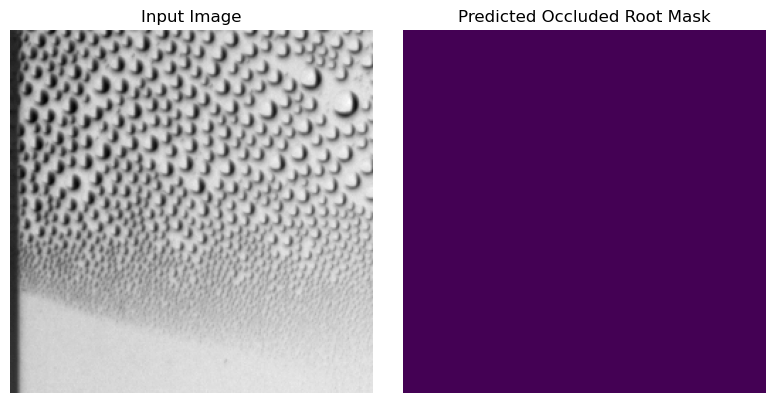

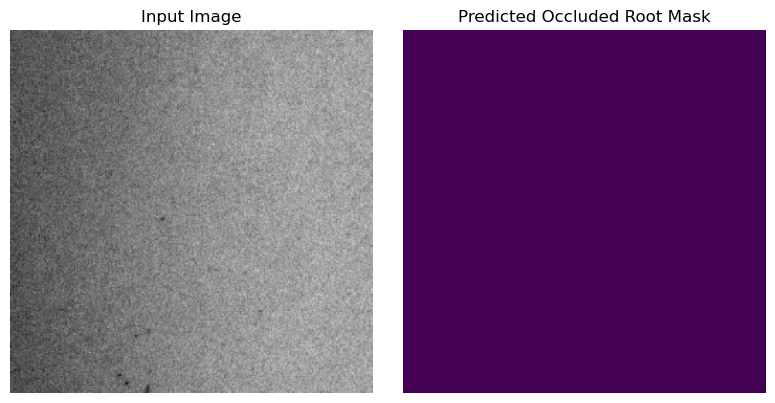

In [68]:
random_indices_3 = np.random.choice(X_test.shape[0], 3, replace=False)

# Save example input images and resulting segmentation masks for occluded_root
for idx in random_indices_3:
    sample_image = X_test[idx]
    sample_mask_pred = occ_root_y_pred[idx] > 0.5
    
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(sample_image, cmap='gray')
    plt.title('Input Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(sample_mask_pred, cmap='viridis', vmin=0, vmax=1)
    plt.title('Predicted Occluded Root Mask')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()